# **<center> Adversarial attacks <center>**



In [1]:
exec(open('cifar_utils.py').read())
from keras.callbacks import ReduceLROnPlateau
import matplotlib.pyplot as plt
from keras.models import load_model
import random

1- Import the cifar dataset

In [70]:
x_train, train_labels, x_test, test_labels = load_CIFAR10_data()
classes = ['airplane','automobile','bird','cat','deer','dog','frog','horse','ship','truck']

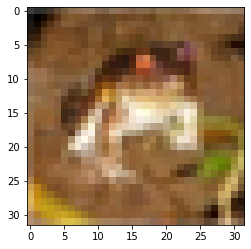

In [3]:
plt.imshow(x_train[0])

2- Train a base model

In [6]:
model = load_model('best_model.h5')

In [ ]:
input_shape = (32,32,3)
model = build_model_base_CNN(input_shape)

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 32)        896       
_________________________________________________________________
batch_normalization (BatchNo (None, 32, 32, 32)        128       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 32)        9248      
_________________________________________________________________
batch_normalization_1 (Batch (None, 32, 32, 32)        128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 16, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 64)        1

In [5]:
## hot encoding of the labels
y_train = keras.utils.to_categorical(train_labels, 10) 
y_test = keras.utils.to_categorical(test_labels, 10)

In [ ]:

rlrop = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5)

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1,patience=15)
mc = ModelCheckpoint('best_model.h5', monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)


history = model.fit(x_train, y_train, epochs=100, batch_size=64,verbose=1,validation_split = 0.2,callbacks=[es,mc,rlrop])


Epoch 1/100
620/625 [============================>.] - ETA: 0s - loss: 2.0795 - accuracy: 0.2629
Epoch 00001: val_accuracy improved from -inf to 0.35920, saving model to best_model.h5
625/625 [==============================] - 5s 8ms/step - loss: 2.0772 - accuracy: 0.2632 - val_loss: 1.7947 - val_accuracy: 0.3592
Epoch 2/100
625/625 [==============================] - ETA: 0s - loss: 1.6141 - accuracy: 0.4165
Epoch 00002: val_accuracy did not improve from 0.35920
625/625 [==============================] - 5s 7ms/step - loss: 1.6141 - accuracy: 0.4165 - val_loss: 2.0535 - val_accuracy: 0.3359
Epoch 3/100
624/625 [============================>.] - ETA: 0s - loss: 1.3660 - accuracy: 0.5142
Epoch 00003: val_accuracy improved from 0.35920 to 0.53120, saving model to best_model.h5
625/625 [==============================] - 5s 8ms/step - loss: 1.3656 - accuracy: 0.5145 - val_loss: 1.4814 - val_accuracy: 0.5312
Epoch 4/100
622/625 [============================>.] - ETA: 0s - loss: 1.1587 - accu

Plot Training loss

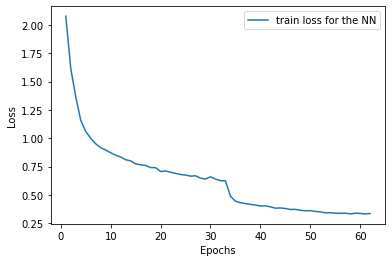

In [ ]:


history_dict = history.history
loss_values = history_dict['loss']

epochs = range(1, len(loss_values) + 1)
plt.plot(epochs, loss_values, label='train loss for the NN')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

Plot validation loss

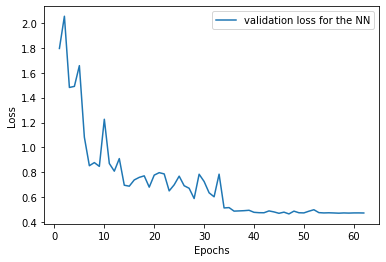

In [ ]:

loss_values = history_dict['val_loss']

epochs = range(1, len(loss_values) + 1)
plt.plot(epochs, loss_values, label='validation loss for the NN')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

3- Evaluate on train and test set 

In [ ]:
print("Base accuracy on regular train images:", model.evaluate(x=x_train, y=y_train, verbose=0)[1])

Base accuracy on regular train images: 0.9287400245666504


In [ ]:
print("Base accuracy on regular test images:", model.evaluate(x=x_test, y=y_test, verbose=0)[1])

Base accuracy on regular test images: 0.8500999808311462


*4 - Generate FGSM ATTACK

Example on one image and different values of epsilon, we plot the predictions as well as the confidence of the predictions



In [ ]:
image = x_train[1,:]
image_label = y_train[1,:].reshape((1,-1))

In [ ]:
perturbations = adversarial_pattern2(image.reshape((-1,32,32,3)), image_label,model).numpy()


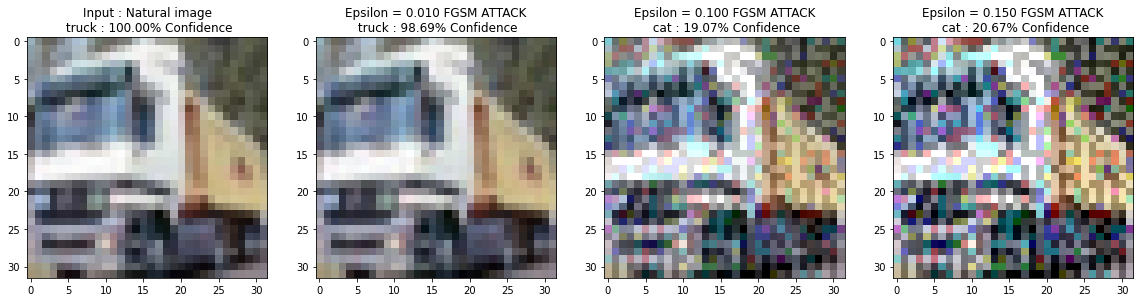

In [ ]:
fig = plt.figure(figsize=(25,5))
epsilons = [0, 0.01, 0.1, 0.15]
descriptions = [('Epsilon = {:0.3f}'.format(eps)+' FGSM ATTACK' if eps else 'Input : Natural image')
                for eps in epsilons]

for i in range(len(epsilons)) : 
  adversarial = image + perturbations * epsilons[i]
  adversarial = tf.clip_by_value(adversarial, 0, 1).numpy()
  label = classes[model.predict(adversarial.reshape(-1,32,32,3)).argmax()]
  confidence = model.predict(adversarial.reshape(-1,32,32,3)).max()
  subplot = fig.add_subplot(1,5,i+1)
  plt.imshow(adversarial.reshape(32,32,3))
  subplot.title.set_text(descriptions[i]+'\n {} : {:.2f}% Confidence'.format(label, confidence*100))

Compute the accuracy of the model on some adversarial examples only :

In [ ]:
batch_size = 10000
eps = 0.1
x_adversarial_test, y_adversarial_test = generate_adversarials_test_FGSM(batch_size, eps,model)



In [ ]:
print("Accuracy on adversarial images for epsilon = 0.1:", model.evaluate(x=np.array(x_adversarial_test).reshape(-1,32,32,3), y=np.array(y_adversarial_test), verbose=0)[1])

Accuracy on adversarial images for epsilon = 0.1: 0.0860000029206276


Plot the accuracy for different epsilons : 

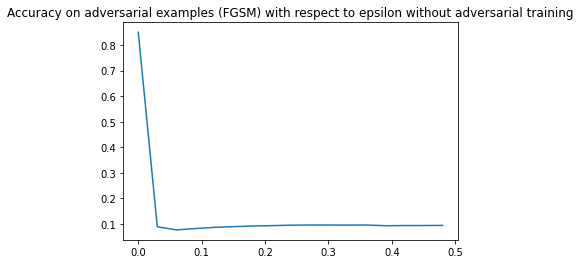

In [ ]:
epsilons2 = np.arange(0,0.5,0.03)
batch_size = 10000
accuracies = []
for eps in epsilons2 :
  x_adversarial_test, y_adversarial_test = generate_adversarials_test_FGSM(batch_size, eps,model)
  accuracy =  model.evaluate(x=np.array(x_adversarial_test).reshape(-1,32,32,3), y=np.array(y_adversarial_test), verbose=0)[1]
  accuracies.append(accuracy)
plt.plot(epsilons2,accuracies)
plt.title('Accuracy on adversarial examples (FGSM) with respect to epsilon without adversarial training')
plt.show()


5- Adversarial training (training on adversarial images )


we generate the first train data : 

In [7]:
##  a portion of adversarial

n_examples = 2*x_train.shape[0]//3
# vector_eps = np.arange(0.01,0.2,0.01)

eps = 0.1
x_adversarial_train, y_adversarial_train = generate_adversarials_train_FGSM(n_examples, eps,model)

## portion of  regular examples
indexes = np.random.choice(x_train.shape[0],2*x_train.shape[0]//3)
x_regular = x_train[indexes]
y_regular = y_train[indexes]
x_train_mixed = np.concatenate([x_regular,x_adversarial_train],axis = 0)
y_train_mixed = np.concatenate([y_regular,y_adversarial_train],axis = 0)
from sklearn.utils import shuffle
x_train_mixed,y_train_mixed = shuffle(x_train_mixed,y_train_mixed, random_state = 0)

define the second model and train it 

In [8]:
input_shape = (32,32,3)
model_adv = build_model_base_CNN(input_shape)

rlrop = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5)
courbes = []
val_courbes = []

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1,patience=15)
mc = ModelCheckpoint('best_model_adv.h5', monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)
for i in range(1, 30):
  print('epoch'+str(i))

  history_adv = model_adv.fit(np.array(x_train_mixed).reshape(-1,32,32,3), np.array(y_train_mixed), epochs=1, batch_size=64,verbose=1,validation_split = 0.2,callbacks=[es,mc,rlrop])


  x_adversarial_train, y_adversarial_train = generate_adversarials_train_FGSM(n_examples, eps,model_adv)
  
  history_dict = history_adv.history
  courbes.append(history_dict['loss'])
  val_courbes.append(history_dict['val_loss'])
  ## portion of  regular examples
  indexes = np.random.choice(x_train.shape[0],2*x_train.shape[0]//3)
  x_regular = x_train[indexes]
  y_regular = y_train[indexes]
  ## prepare data for next epoch
  x_train_mixed = np.concatenate([x_regular,x_adversarial_train],axis = 0)
  y_train_mixed = np.concatenate([y_regular,y_adversarial_train],axis = 0)
  x_train_mixed,y_train_mixed = shuffle(x_train_mixed,y_train_mixed, random_state = 0)

epoch1
834/834 [==============================] - ETA: 0s - loss: 2.0673 - accuracy: 0.2647
Epoch 00001: val_accuracy improved from -inf to 0.38286, saving model to best_model_adv.h5
834/834 [==============================] - 5s 6ms/step - loss: 2.0673 - accuracy: 0.2647 - val_loss: 1.6681 - val_accuracy: 0.3829
epoch2
824/834 [============================>.] - ETA: 0s - loss: 1.7518 - accuracy: 0.3575
Epoch 00001: val_accuracy did not improve from 0.38286
834/834 [==============================] - 5s 6ms/step - loss: 1.7494 - accuracy: 0.3585 - val_loss: 1.9505 - val_accuracy: 0.3487
epoch3
826/834 [============================>.] - ETA: 0s - loss: 1.4336 - accuracy: 0.4722
Epoch 00001: val_accuracy improved from 0.38286 to 0.61864, saving model to best_model_adv.h5
834/834 [==============================] - 5s 6ms/step - loss: 1.4309 - accuracy: 0.4731 - val_loss: 1.0622 - val_accuracy: 0.6186
epoch4
829/834 [============================>.] - ETA: 0s - loss: 1.4475 - accuracy: 0.4705

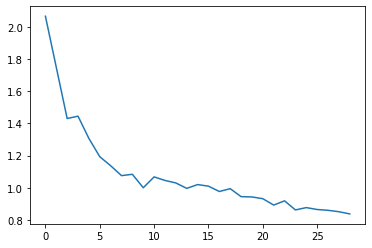

In [9]:
plt.plot(courbes)

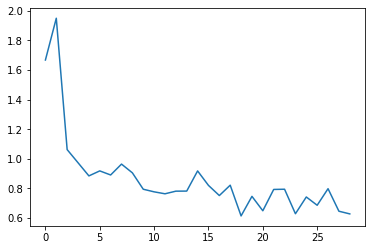

In [10]:
plt.plot(val_courbes)


In [11]:
print("Defended accuracy on regular images:", model_adv.evaluate(x=x_test, y=y_test, verbose=0)[1])

Defended accuracy on regular images: 0.7272999882698059


In [12]:
batch_size = 10000
eps = 0.1
x_adversarial_new, y_adversarial_new = generate_adversarials_test_FGSM(batch_size, eps,model_adv)



In [13]:
print("Defended accuracy on adversarial images:", model_adv.evaluate(x=np.array(x_adversarial_new).reshape(-1,32,32,3), y=np.array(y_adversarial_new), verbose=0)[1])

Defended accuracy on adversarial images: 0.6658999919891357


Results of adversarial training : 
* The accuracy on regular test images is a little less that the accuracy  obtained by normal neural network. <br>
* The accuracy on adversarial test images  was significantly improved 

Defended accuracy as a function of epsilon

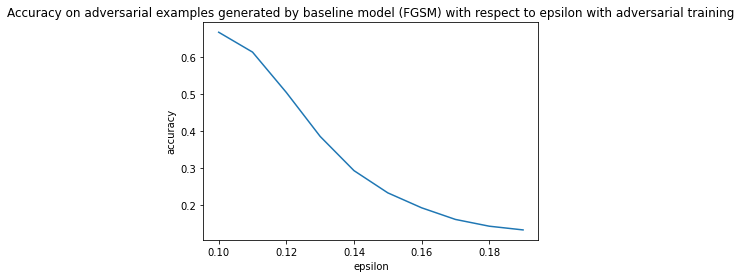

In [27]:
epsilons2 = np.arange(0.1,0.2,0.01)
batch_size = 10000
accuracies = []
for eps in epsilons2 :
  x_adversarial_test, y_adversarial_test = generate_adversarials_test_FGSM(batch_size, eps, model_adv)
  accuracy =  model_adv.evaluate(x=np.array(x_adversarial_test).reshape(-1,32,32,3), y=np.array(y_adversarial_test), verbose=0)[1]
  accuracies.append(accuracy)
plt.plot(epsilons2,accuracies)
plt.xlabel('epsilon') 
plt.ylabel('accuracy')
plt.title('Accuracy on adversarial examples generated by baseline model (FGSM) with respect to epsilon with adversarial training')

plt.show()


# A method for improving the robustness against attacks : Denoising feature maps


Code of denoising blocks is taken from this official repo : https://github.com/facebookresearch/ImageNet-Adversarial-Training/blob/master/resnet_model.py

Define the model with one denoising block after the  first convolution, It is the model we want to attack

In [15]:
def build_model_denois(input_shape):
  input = keras.Input(shape=input_shape, name='input')
  x = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same')(input)
  x = BatchNormalization()(x)
    # ###denoising block
  f = non_local_op(x, embed=False, softmax=False)
  f = Conv2D(x.shape[1], 1, strides=1, activation='relu')(f)
  
  y = tf.keras.layers.Add()([f, x])
  y = BatchNormalization()(y)
  
  # ##################
  x = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same')(y)
  x = BatchNormalization()(x)
  
  y = MaxPooling2D((2, 2))(x)
  y = Dropout(0.3)(y)

  x = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same')(y)
  x = BatchNormalization()(x)
  x = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same')(x)
  x = BatchNormalization()(x)

  y = MaxPooling2D((2, 2))(x)
  y = Dropout(0.3)(y)


  z = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same')(y)
  z = BatchNormalization()(z)
  z = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same')(z)
  z = BatchNormalization()(z)

  y = MaxPooling2D((2, 2))(z)
  y = Dropout(0.3)(y)
  y = Flatten()(y)
  y = Dense(128, activation='relu', kernel_initializer='he_uniform')(y)
  y = Dropout(0.3)(y)
  y = Dense(10, activation='softmax')(y)
  model = keras.Model(inputs=input, outputs=y)
  opt = SGD(lr=0.01, momentum=0.9)
  op = Adam(lr=0.01)
  model.compile(optimizer=op, loss='categorical_crossentropy', metrics=['accuracy'])

  return model

In [16]:
##  a portion of adversarial

n_examples = 2*x_train.shape[0]//3
eps = 0.1
x_adversarial_train, y_adversarial_train = generate_adversarials_train_FGSM(n_examples, eps,model)

## portion of  regular examples
indexes = np.random.choice(x_train.shape[0],2*x_train.shape[0]//3)
x_regular = x_train[indexes]
y_regular = y_train[indexes]
x_train_mixed = np.concatenate([x_regular,x_adversarial_train],axis = 0)
y_train_mixed = np.concatenate([y_regular,y_adversarial_train],axis = 0)
from sklearn.utils import shuffle
x_train_mixed,y_train_mixed = shuffle(x_train_mixed,y_train_mixed, random_state = 0)

In [17]:

denoised = build_model_denois(input_shape)

In [118]:
denoised.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv2d_6 (Conv2D)               (None, 32, 32, 32)   896         input[0][0]                      
__________________________________________________________________________________________________
batch_normalization_6 (BatchNor (None, 32, 32, 32)   128         conv2d_6[0][0]                   
__________________________________________________________________________________________________
tf_op_layer_Einsum (TensorFlowO [(None, 32, 32)]     0           batch_normalization_6[0][0]      
                                                                 batch_normalization_6[

In [19]:

rlrop = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5)

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1,patience=15)
mc = ModelCheckpoint('best_model_denoised.h5', monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)



In [20]:
courbes_denois = []
val_courbes_denois = []
eps = 0.1
for i in range(1,30):
  print('epoch'+str(i))

  history_denois = denoised.fit(np.array(x_train_mixed).reshape(-1,32,32,3), np.array(y_train_mixed), epochs=1, batch_size=64,verbose=1,validation_split = 0.2,callbacks=[es,mc,rlrop])
  history_dict = history_denois.history
  courbes_denois.append(history_dict['loss'])
  val_courbes_denois.append(history_dict['val_loss'])
  x_adversarial_train, y_adversarial_train = generate_adversarials_train_FGSM(n_examples, eps,denoised)

  ## portion of  regular examples
  indexes = np.random.choice(x_train.shape[0],2*x_train.shape[0]//3)
  x_regular = x_train[indexes]
  y_regular = y_train[indexes]
  ## prepare data for next epoch
  x_train_mixed = np.concatenate([x_regular,x_adversarial_train],axis = 0)
  y_train_mixed = np.concatenate([y_regular,y_adversarial_train],axis = 0)
  x_train_mixed,y_train_mixed = shuffle(x_train_mixed,y_train_mixed, random_state = 0)

epoch1
834/834 [==============================] - ETA: 0s - loss: 2.1331 - accuracy: 0.2163
Epoch 00001: val_accuracy improved from -inf to 0.31941, saving model to best_model_denoised.h5
834/834 [==============================] - 6s 7ms/step - loss: 2.1331 - accuracy: 0.2163 - val_loss: 1.7887 - val_accuracy: 0.3194
epoch2
826/834 [============================>.] - ETA: 0s - loss: 1.7610 - accuracy: 0.3436
Epoch 00001: val_accuracy improved from 0.31941 to 0.48808, saving model to best_model_denoised.h5
834/834 [==============================] - 6s 7ms/step - loss: 1.7587 - accuracy: 0.3443 - val_loss: 1.3656 - val_accuracy: 0.4881
epoch3
829/834 [============================>.] - ETA: 0s - loss: 1.7779 - accuracy: 0.3205
Epoch 00001: val_accuracy improved from 0.48808 to 0.55332, saving model to best_model_denoised.h5
834/834 [==============================] - 7s 8ms/step - loss: 1.7754 - accuracy: 0.3216 - val_loss: 1.2643 - val_accuracy: 0.5533
epoch4
832/834 [=====================

In [21]:

print("accuracy on regular images:", denoised.evaluate(x=x_test, y=y_test, verbose=0)[1])

accuracy on regular images: 0.7368999719619751


In [22]:
batch_size = 10000
eps = 0.1
x_adversarial_denois, y_adversarial_denois = generate_adversarials_test_FGSM(batch_size, eps,denoised)



In [23]:
print("accuracy on adversarial images:", denoised.evaluate(x=np.array(x_adversarial_denois).reshape(-1,32,32,3), y=np.array(y_adversarial_denois), verbose=0)[1])

accuracy on adversarial images: 0.6291999816894531


In [26]:
epsilons2 = np.arange(0.1,0.2,0.01)
batch_size = 10000
accuracies_denoised = []
for eps in epsilons2 :
  x_adversarial_test, y_adversarial_test = generate_adversarials_test_FGSM(batch_size, eps, denoised)
  accuracy =  denoised.evaluate(x=np.array(x_adversarial_test).reshape(-1,32,32,3), y=np.array(y_adversarial_test), verbose=0)[1]
  accuracies_denoised.append(accuracy)



Comparison of the classical adversarial training

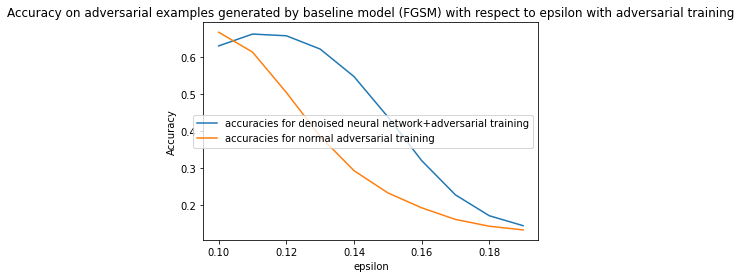

In [29]:
plt.plot(epsilons2,accuracies_denoised, label = 'accuracies for denoised neural network+adversarial training')
plt.plot(epsilons2,accuracies,label='accuracies for normal adversarial training')
plt.title('Accuracy on adversarial examples generated by baseline model (FGSM) with respect to epsilon with adversarial training')
plt.xlabel('epsilon')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

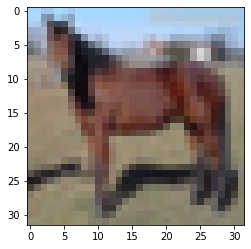

In [72]:
image = x_test[800]
image_label = y_test[800].reshape((1,-1))

perturbations = adversarial_pattern2(image.reshape((-1,32,32,3)), image_label,denoised).numpy()
adversarial = image + perturbations * 0.12
adversarial = tf.clip_by_value(adversarial, 0, 1).numpy()

plt.imshow(image)

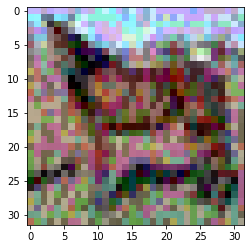

In [73]:
plt.imshow(adversarial.reshape((32,32,3)))

In [74]:
classes[denoised.predict(adversarial.reshape(-1,32,32,3)).argmax()]

'horse'

(1, 32, 32, 32)


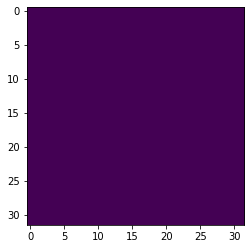

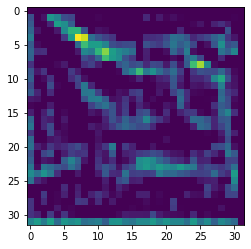

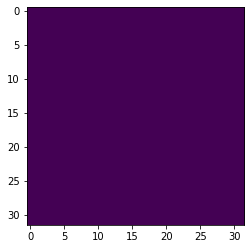

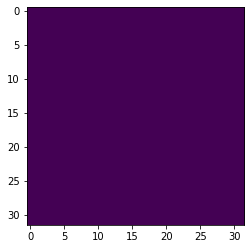

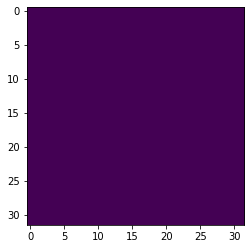

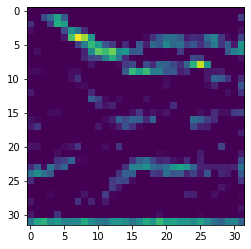

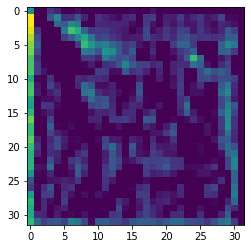

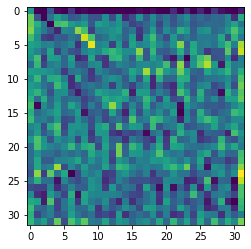

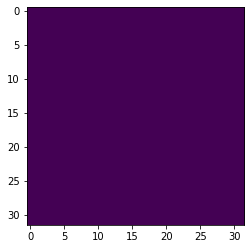

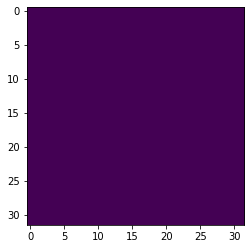

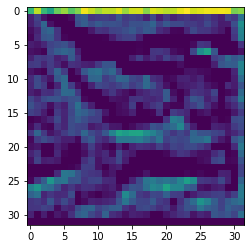

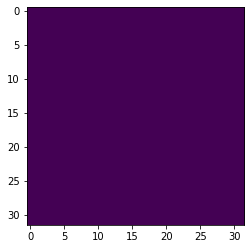

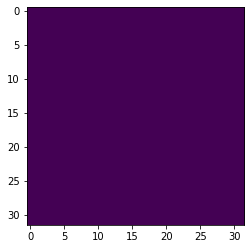

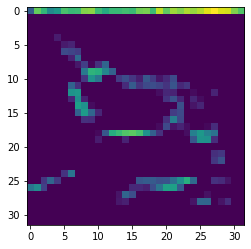

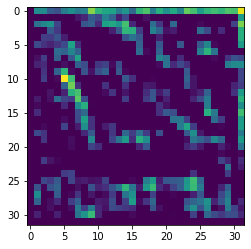

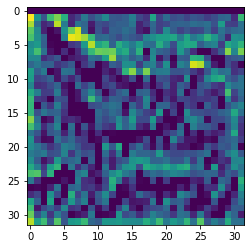

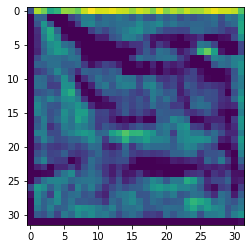

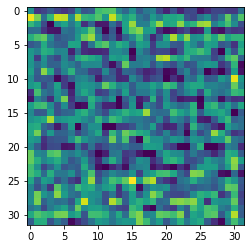

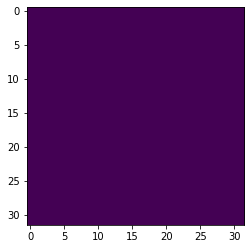

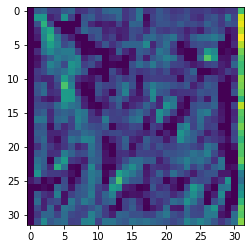

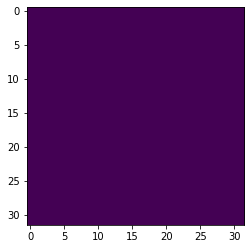

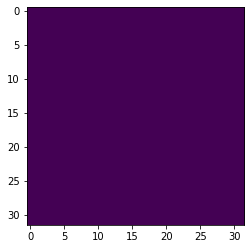

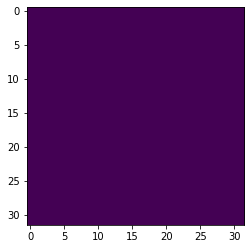

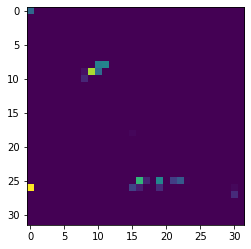

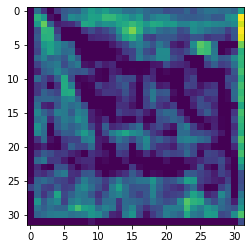

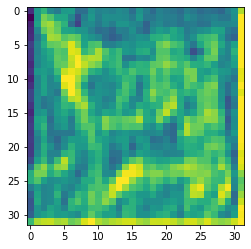

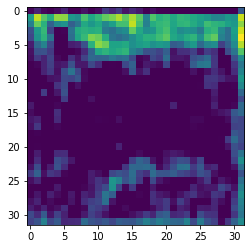

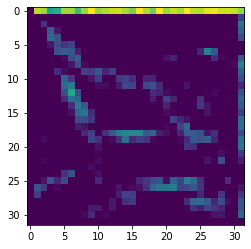

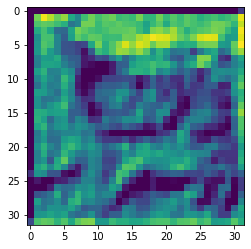

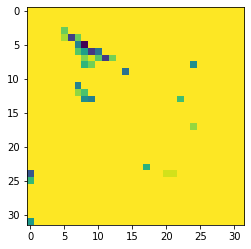

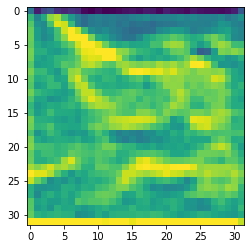

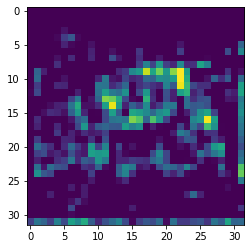

tf_op_layer_Reshape
(1, 32, 32, 32)


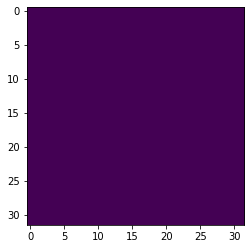

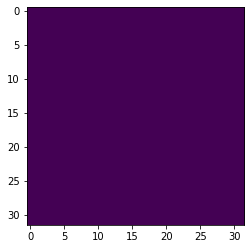

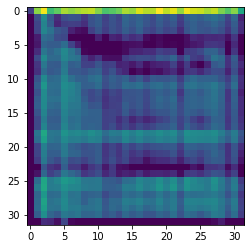

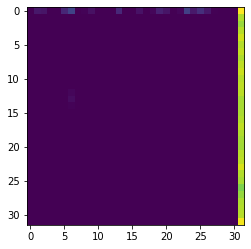

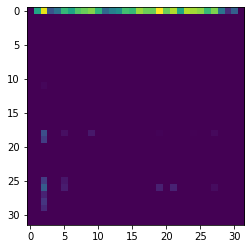

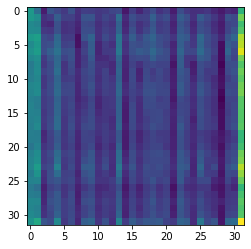

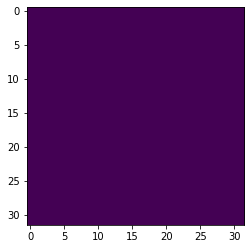

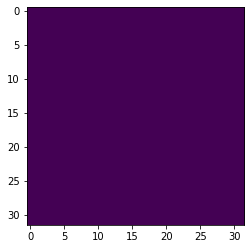

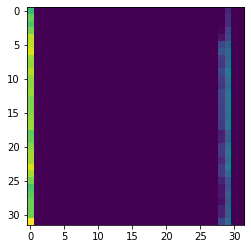

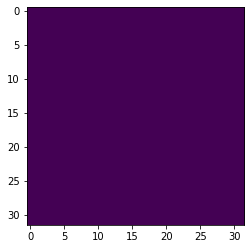

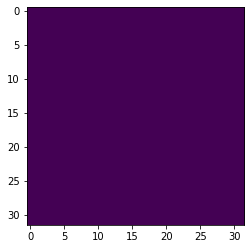

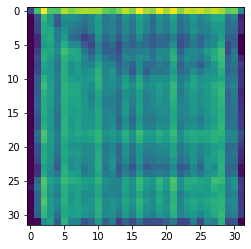

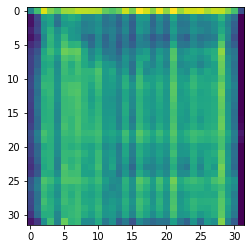

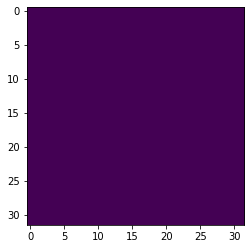

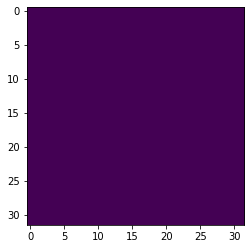

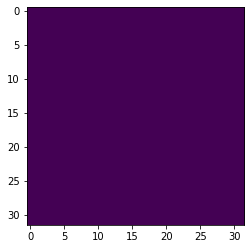

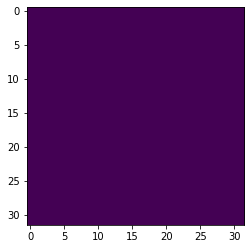

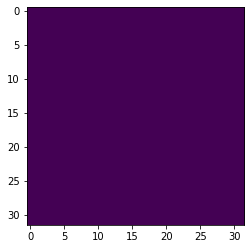

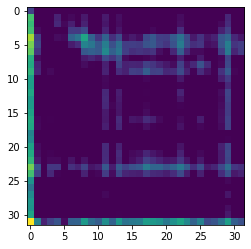

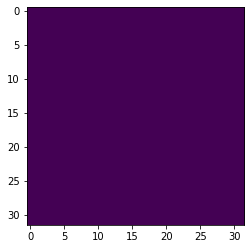

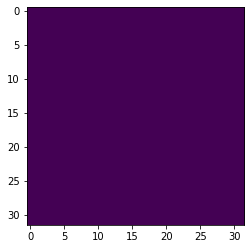

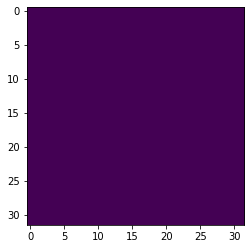

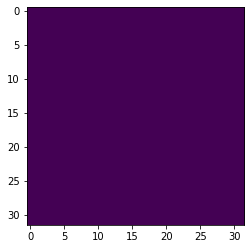

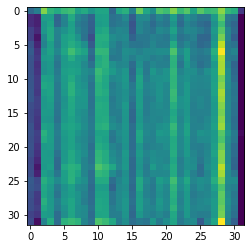

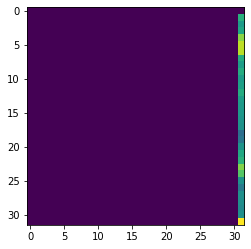

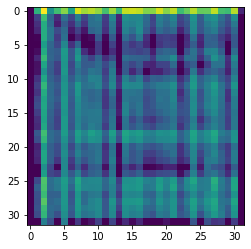

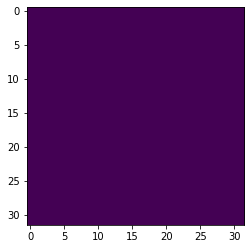

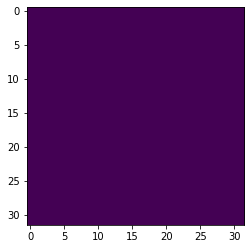

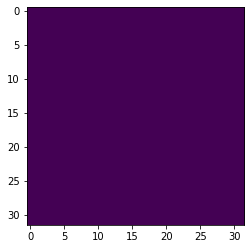

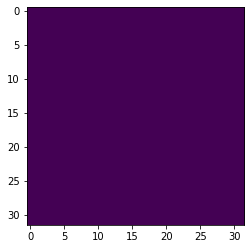

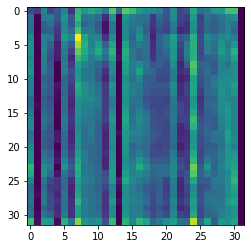

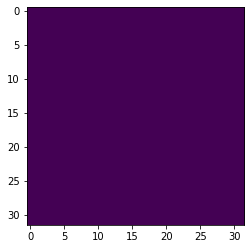

In [147]:
successive_outputs = [layer.output for layer in denoised.layers[1:]]

visualization_model = tf.keras.models.Model(inputs = denoised.input, outputs = successive_outputs)

successive_feature_maps = visualization_model.predict(adversarial.reshape(-1,32,32,3))

# Retrieve are the names of the layers, so can have them as part of our plot
layer_names = [layer.name for layer in denoised.layers]
i = 0
for layer_name, feature_map in zip(layer_names, successive_feature_maps):
  i = i+1

  if layer_name == 'conv2d_6':
    print(feature_map.shape)
    for j in range(32) :
      plt.imshow( feature_map[:,:,:,j].reshape((32,32)))
      plt.show()
  # if i == 6:
  if layer_name == 'tf_op_layer_Reshape':
    print(layer_name)
    print(feature_map.shape)
    for j in range(32) :
      plt.imshow( feature_map[:,:,:,j].reshape((32,32)))
      plt.show()